In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [ ]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_4um_back_10M_300keV.pkl")

In [ ]:
len(df.event.unique())

# Generate random multi-electron events

In [9]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

Created dataset for events from 0 to 198917


In [10]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [11]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 40):
    
    A = fit_img/np.max(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,1.5*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [12]:
# Create some number of events and count them.
th_unet = 0.5
th_classical = 825/4.
evts = np.arange(0,10000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


In [13]:
raw_th = 0.99
ct_th = 0.05
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

nzeros = 26.39762589680869, ncts = 1801.2041352760098, wcts = 0.014655543688702234
m =  -1.97109375 b =  86.6953125 Lmin= -51.383880300121746
nzeros = 1835.0, ncts = 714.2857142857142, wcts = 2.5690000000000004
m =  -1.9989257812500023 b =  89.0068359375 Lmin= -3660.0
nzeros = 2503.304347826087, ncts = 232.17391304347825, wcts = 10.782022471910112
m =  -1.6957031250000012 b =  81.52734375 Lmin= -3449.5032730825596
nzeros = 2168.6571428571433, ncts = 282.37142857142857, wcts = 7.680157846807651
m =  -1.9728082180023194 b =  91.34021186828613 Lmin= -3787.9151038579967


Total counts, truth: 10000.0
Total counts, classical: 10000.0
Total counts, unet: 5793


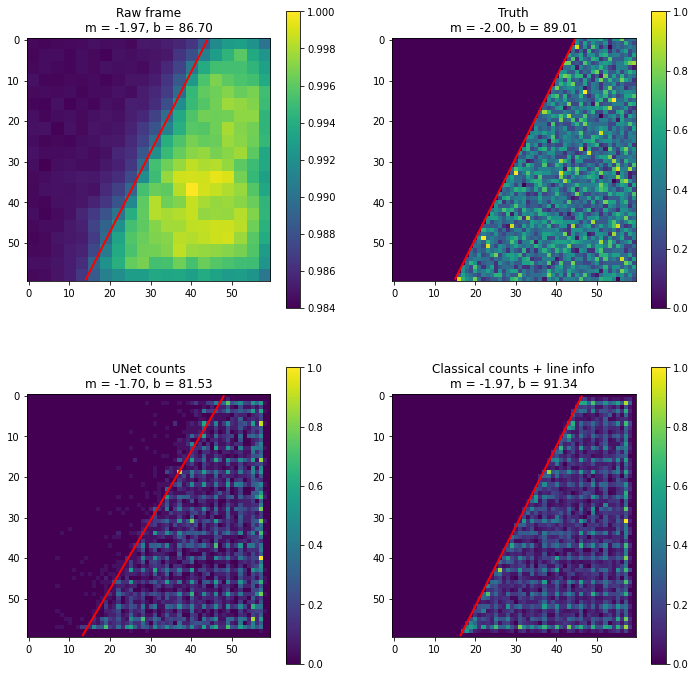

In [14]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

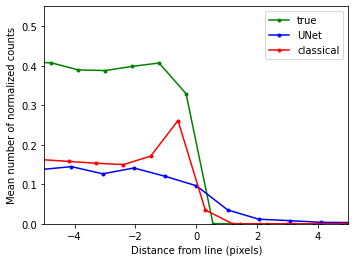

In [15]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
#plt.plot(bcenters_frame,hdist_frame,color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical')
plt.xlim([-5,5])
plt.ylim([0.0,0.55])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th08.npz", bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(111)
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='black',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([0,5])
plt.ylim([0,0.08])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 500    # Number of final epoch
model_load_checkpoint = "{}/model_init_499.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 198917


In [3]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  0


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/1000 (0%)]	Loss: 2919.307373	 score_max: 30.051758	 score_min: -0.438335; Accuracy 0.911
Train Epoch: 0 [50/1000 (5%)]	Loss: 2626.094238	 score_max: 2.173426	 score_min: -1.204874; Accuracy 0.999
Train Epoch: 0 [100/1000 (10%)]	Loss: 2346.075684	 score_max: 0.389061	 score_min: -2.752007; Accuracy 1.000
Train Epoch: 0 [150/1000 (15%)]	Loss: 2057.337158	 score_max: 0.110476	 score_min: -10.187320; Accuracy 1.000
Train Epoch: 0 [200/1000 (20%)]	Loss: 1788.365845	 score_max: 0.035645	 score_min: -6.040158; Accuracy 1.000
Train Epoch: 0 [250/1000 (25%)]	Loss: 1556.872437	 score_max: -0.029135	 score_min: -10.986994; Accuracy 1.000
Train Epoch: 0 [300/1000 (30%)]	Loss: 1344.618774	 score_max: -0.066002	 score_min: -4.716399; Accuracy 1.000
Train Epoch: 0 [350/1000 (35%)]	Loss: 1154.905151	 score_max: -0.094198	 score_min: -3.561500; Accuracy 1.000
Train Epoch: 0 [400/1000 (40%)]	Loss: 932.267029	 score_max: -0.123171	 score_min: -7.854055; Accuracy 1.000
Train Epoch: 0 [45

Train Epoch: 3 [700/1000 (70%)]	Loss: 2.831796	 score_max: -0.735300	 score_min: -42.044067; Accuracy 1.000
Train Epoch: 3 [750/1000 (75%)]	Loss: 2.957387	 score_max: -0.798547	 score_min: -68.581902; Accuracy 1.000
Train Epoch: 3 [800/1000 (80%)]	Loss: 2.877966	 score_max: -0.849506	 score_min: -93.911148; Accuracy 1.000
Train Epoch: 3 [850/1000 (85%)]	Loss: 3.242256	 score_max: -0.720107	 score_min: -57.201168; Accuracy 1.000
Train Epoch: 3 [900/1000 (90%)]	Loss: 2.502979	 score_max: -0.713263	 score_min: -38.826271; Accuracy 1.000
Train Epoch: 3 [950/1000 (95%)]	Loss: 2.531739	 score_max: -0.708520	 score_min: -119.217247; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 2.836960697174072 ACCURACY: 0.9997222423553467
Epoch:  4
Train Epoch: 4 [0/1000 (0%)]	Loss: 3.285501	 score_max: -0.705661	 score_min: -53.788361; Accuracy 1.000
Train Epoch: 4 [50/1000 (5%)]	Loss: 2.641536	 score_max: -0.704490	 score_min: -48.309929; Accuracy 1.000
Train Epoch: 4 [100/1000 (10%)]	Loss: 3.056624	 score_max:

Train Epoch: 7 [350/1000 (35%)]	Loss: 2.146007	 score_max: -0.445544	 score_min: -140.962219; Accuracy 1.000
Train Epoch: 7 [400/1000 (40%)]	Loss: 2.781871	 score_max: -0.440689	 score_min: -76.452553; Accuracy 1.000
Train Epoch: 7 [450/1000 (45%)]	Loss: 2.727688	 score_max: -0.435105	 score_min: -72.667191; Accuracy 1.000
Train Epoch: 7 [500/1000 (50%)]	Loss: 2.749467	 score_max: -0.428869	 score_min: -80.493752; Accuracy 1.000
Train Epoch: 7 [550/1000 (55%)]	Loss: 2.191591	 score_max: -0.422483	 score_min: -103.365654; Accuracy 1.000
Train Epoch: 7 [600/1000 (60%)]	Loss: 2.921039	 score_max: -0.415526	 score_min: -77.599625; Accuracy 1.000
Train Epoch: 7 [650/1000 (65%)]	Loss: 2.080632	 score_max: -0.409260	 score_min: -107.415604; Accuracy 1.000
Train Epoch: 7 [700/1000 (70%)]	Loss: 2.127803	 score_max: -0.402408	 score_min: -86.194267; Accuracy 1.000
Train Epoch: 7 [750/1000 (75%)]	Loss: 2.212703	 score_max: -0.396680	 score_min: -94.069389; Accuracy 1.000
Train Epoch: 7 [800/1000 

Train Epoch: 11 [0/1000 (0%)]	Loss: 2.093545	 score_max: -0.072082	 score_min: -76.068985; Accuracy 1.000
Train Epoch: 11 [50/1000 (5%)]	Loss: 2.022722	 score_max: -0.069592	 score_min: -80.350914; Accuracy 1.000
Train Epoch: 11 [100/1000 (10%)]	Loss: 2.684539	 score_max: -0.068189	 score_min: -70.322250; Accuracy 1.000
Train Epoch: 11 [150/1000 (15%)]	Loss: 2.383899	 score_max: -0.065781	 score_min: -75.505608; Accuracy 1.000
Train Epoch: 11 [200/1000 (20%)]	Loss: 2.269735	 score_max: -0.062470	 score_min: -160.965179; Accuracy 1.000
Train Epoch: 11 [250/1000 (25%)]	Loss: 2.438734	 score_max: -0.058347	 score_min: -132.012070; Accuracy 1.000
Train Epoch: 11 [300/1000 (30%)]	Loss: 2.296977	 score_max: -0.053496	 score_min: -61.617798; Accuracy 1.000
Train Epoch: 11 [350/1000 (35%)]	Loss: 2.523730	 score_max: -0.050068	 score_min: -181.125854; Accuracy 1.000
Train Epoch: 11 [400/1000 (40%)]	Loss: 2.696987	 score_max: -0.046170	 score_min: -94.025192; Accuracy 1.000
Train Epoch: 11 [450/

Train Epoch: 14 [700/1000 (70%)]	Loss: 2.008174	 score_max: 0.227724	 score_min: -92.982079; Accuracy 1.000
Train Epoch: 14 [750/1000 (75%)]	Loss: 2.045526	 score_max: 0.232608	 score_min: -48.103893; Accuracy 1.000
Train Epoch: 14 [800/1000 (80%)]	Loss: 2.464993	 score_max: 0.238167	 score_min: -143.239944; Accuracy 1.000
Train Epoch: 14 [850/1000 (85%)]	Loss: 2.308196	 score_max: 0.242407	 score_min: -74.003647; Accuracy 1.000
Train Epoch: 14 [900/1000 (90%)]	Loss: 2.030950	 score_max: 0.247386	 score_min: -71.362511; Accuracy 1.000
Train Epoch: 14 [950/1000 (95%)]	Loss: 1.703698	 score_max: 0.253027	 score_min: -79.697021; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 2.160897833108902 ACCURACY: 0.9997222423553467
Epoch:  15
Train Epoch: 15 [0/1000 (0%)]	Loss: 1.998553	 score_max: 0.259264	 score_min: -77.775749; Accuracy 1.000
Train Epoch: 15 [50/1000 (5%)]	Loss: 2.507657	 score_max: 0.264299	 score_min: -78.311142; Accuracy 1.000
Train Epoch: 15 [100/1000 (10%)]	Loss: 1.921406	 score_ma

Train Epoch: 18 [350/1000 (35%)]	Loss: 1.807122	 score_max: 0.358924	 score_min: -66.655182; Accuracy 1.000
Train Epoch: 18 [400/1000 (40%)]	Loss: 1.545497	 score_max: 0.359774	 score_min: -145.403610; Accuracy 1.000
Train Epoch: 18 [450/1000 (45%)]	Loss: 2.206609	 score_max: 0.360659	 score_min: -143.794006; Accuracy 1.000
Train Epoch: 18 [500/1000 (50%)]	Loss: 2.126414	 score_max: 0.361484	 score_min: -147.636673; Accuracy 1.000
Train Epoch: 18 [550/1000 (55%)]	Loss: 1.850451	 score_max: 0.362209	 score_min: -58.487930; Accuracy 1.000
Train Epoch: 18 [600/1000 (60%)]	Loss: 2.176043	 score_max: 0.362922	 score_min: -67.817589; Accuracy 1.000
Train Epoch: 18 [650/1000 (65%)]	Loss: 1.759206	 score_max: 0.363614	 score_min: -72.662003; Accuracy 1.000
Train Epoch: 18 [700/1000 (70%)]	Loss: 1.913070	 score_max: 0.364200	 score_min: -63.340763; Accuracy 1.000
Train Epoch: 18 [750/1000 (75%)]	Loss: 1.667576	 score_max: 0.364801	 score_min: -85.023460; Accuracy 1.000
Train Epoch: 18 [800/1000

Train Epoch: 22 [0/1000 (0%)]	Loss: 2.372416	 score_max: 0.415936	 score_min: -130.033783; Accuracy 1.000
Train Epoch: 22 [50/1000 (5%)]	Loss: 2.014834	 score_max: 0.416327	 score_min: -100.657402; Accuracy 1.000
Train Epoch: 22 [100/1000 (10%)]	Loss: 2.132987	 score_max: 0.416777	 score_min: -109.554520; Accuracy 1.000
Train Epoch: 22 [150/1000 (15%)]	Loss: 1.711016	 score_max: 0.417307	 score_min: -103.413544; Accuracy 1.000
Train Epoch: 22 [200/1000 (20%)]	Loss: 1.942711	 score_max: 0.417685	 score_min: -151.592194; Accuracy 1.000
Train Epoch: 22 [250/1000 (25%)]	Loss: 2.223603	 score_max: 0.418151	 score_min: -82.357285; Accuracy 1.000
Train Epoch: 22 [300/1000 (30%)]	Loss: 2.115173	 score_max: 0.418668	 score_min: -73.190323; Accuracy 1.000
Train Epoch: 22 [350/1000 (35%)]	Loss: 1.507155	 score_max: 0.419233	 score_min: -95.013657; Accuracy 1.000
Train Epoch: 22 [400/1000 (40%)]	Loss: 1.437523	 score_max: 0.419867	 score_min: -92.432228; Accuracy 1.000
Train Epoch: 22 [450/1000 (4

Train Epoch: 25 [700/1000 (70%)]	Loss: 1.704564	 score_max: 0.441505	 score_min: -111.490395; Accuracy 1.000
Train Epoch: 25 [750/1000 (75%)]	Loss: 1.413399	 score_max: 0.441606	 score_min: -191.608841; Accuracy 1.000
Train Epoch: 25 [800/1000 (80%)]	Loss: 1.844108	 score_max: 0.441709	 score_min: -66.110298; Accuracy 1.000
Train Epoch: 25 [850/1000 (85%)]	Loss: 1.336464	 score_max: 0.441814	 score_min: -183.215256; Accuracy 1.000
Train Epoch: 25 [900/1000 (90%)]	Loss: 1.958288	 score_max: 0.441922	 score_min: -170.502838; Accuracy 1.000
Train Epoch: 25 [950/1000 (95%)]	Loss: 1.915530	 score_max: 0.442028	 score_min: -104.288200; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.7602153718471527 ACCURACY: 0.9997222423553467
Epoch:  26
Train Epoch: 26 [0/1000 (0%)]	Loss: 1.680954	 score_max: 0.442137	 score_min: -148.608521; Accuracy 1.000
Train Epoch: 26 [50/1000 (5%)]	Loss: 2.076020	 score_max: 0.442247	 score_min: -126.680695; Accuracy 1.000
Train Epoch: 26 [100/1000 (10%)]	Loss: 1.482058	 s

Train Epoch: 29 [350/1000 (35%)]	Loss: 2.177343	 score_max: 0.448182	 score_min: -121.320694; Accuracy 1.000
Train Epoch: 29 [400/1000 (40%)]	Loss: 1.863352	 score_max: 0.448190	 score_min: -176.237656; Accuracy 1.000
Train Epoch: 29 [450/1000 (45%)]	Loss: 2.584956	 score_max: 0.448198	 score_min: -117.727592; Accuracy 1.000
Train Epoch: 29 [500/1000 (50%)]	Loss: 2.095590	 score_max: 0.448205	 score_min: -78.177101; Accuracy 1.000
Train Epoch: 29 [550/1000 (55%)]	Loss: 1.811518	 score_max: 0.448214	 score_min: -80.777138; Accuracy 1.000
Train Epoch: 29 [600/1000 (60%)]	Loss: 1.957040	 score_max: 0.448222	 score_min: -118.388268; Accuracy 1.000
Train Epoch: 29 [650/1000 (65%)]	Loss: 2.235450	 score_max: 0.448230	 score_min: -103.771233; Accuracy 1.000
Train Epoch: 29 [700/1000 (70%)]	Loss: 2.143929	 score_max: 0.448238	 score_min: -105.568748; Accuracy 1.000
Train Epoch: 29 [750/1000 (75%)]	Loss: 1.728922	 score_max: 0.448246	 score_min: -96.299736; Accuracy 1.000
Train Epoch: 29 [800/1

Train Epoch: 33 [0/1000 (0%)]	Loss: 1.762402	 score_max: 0.448625	 score_min: -101.399750; Accuracy 1.000
Train Epoch: 33 [50/1000 (5%)]	Loss: 1.835391	 score_max: 0.448626	 score_min: -89.776527; Accuracy 1.000
Train Epoch: 33 [100/1000 (10%)]	Loss: 1.715467	 score_max: 0.448627	 score_min: -79.661148; Accuracy 1.000
Train Epoch: 33 [150/1000 (15%)]	Loss: 1.807076	 score_max: 0.448627	 score_min: -83.813843; Accuracy 1.000
Train Epoch: 33 [200/1000 (20%)]	Loss: 2.060824	 score_max: 0.448628	 score_min: -62.811970; Accuracy 1.000
Train Epoch: 33 [250/1000 (25%)]	Loss: 2.051075	 score_max: 0.448629	 score_min: -114.881279; Accuracy 1.000
Train Epoch: 33 [300/1000 (30%)]	Loss: 1.701308	 score_max: 0.448630	 score_min: -112.348251; Accuracy 1.000
Train Epoch: 33 [350/1000 (35%)]	Loss: 1.904053	 score_max: 0.448631	 score_min: -105.651329; Accuracy 1.000
Train Epoch: 33 [400/1000 (40%)]	Loss: 1.984851	 score_max: 0.448632	 score_min: -89.074837; Accuracy 1.000
Train Epoch: 33 [450/1000 (45

Train Epoch: 36 [700/1000 (70%)]	Loss: 1.590382	 score_max: 0.448656	 score_min: -118.581863; Accuracy 1.000
Train Epoch: 36 [750/1000 (75%)]	Loss: 1.991223	 score_max: 0.448656	 score_min: -117.373062; Accuracy 1.000
Train Epoch: 36 [800/1000 (80%)]	Loss: 1.969953	 score_max: 0.448656	 score_min: -77.058411; Accuracy 1.000
Train Epoch: 36 [850/1000 (85%)]	Loss: 1.743782	 score_max: 0.448656	 score_min: -115.486916; Accuracy 1.000
Train Epoch: 36 [900/1000 (90%)]	Loss: 2.180636	 score_max: 0.448656	 score_min: -120.892097; Accuracy 1.000
Train Epoch: 36 [950/1000 (95%)]	Loss: 1.796786	 score_max: 0.448657	 score_min: -106.138008; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.8217631042003632 ACCURACY: 0.9997222423553467
Epoch:  37
Train Epoch: 37 [0/1000 (0%)]	Loss: 1.880977	 score_max: 0.448657	 score_min: -152.379166; Accuracy 1.000
Train Epoch: 37 [50/1000 (5%)]	Loss: 1.882270	 score_max: 0.448657	 score_min: -99.310127; Accuracy 1.000
Train Epoch: 37 [100/1000 (10%)]	Loss: 2.128531	 sc

Train Epoch: 40 [350/1000 (35%)]	Loss: 1.654331	 score_max: 0.448662	 score_min: -135.531158; Accuracy 1.000
Train Epoch: 40 [400/1000 (40%)]	Loss: 1.941107	 score_max: 0.448662	 score_min: -99.013100; Accuracy 1.000
Train Epoch: 40 [450/1000 (45%)]	Loss: 1.828613	 score_max: 0.448662	 score_min: -99.956223; Accuracy 1.000
Train Epoch: 40 [500/1000 (50%)]	Loss: 2.003288	 score_max: 0.448662	 score_min: -127.352348; Accuracy 1.000
Train Epoch: 40 [550/1000 (55%)]	Loss: 2.021796	 score_max: 0.448662	 score_min: -89.354797; Accuracy 1.000
Train Epoch: 40 [600/1000 (60%)]	Loss: 1.538385	 score_max: 0.448662	 score_min: -97.158035; Accuracy 1.000
Train Epoch: 40 [650/1000 (65%)]	Loss: 1.668991	 score_max: 0.448662	 score_min: -114.396858; Accuracy 1.000
Train Epoch: 40 [700/1000 (70%)]	Loss: 1.708262	 score_max: 0.448662	 score_min: -125.890106; Accuracy 1.000
Train Epoch: 40 [750/1000 (75%)]	Loss: 1.478748	 score_max: 0.448662	 score_min: -65.538879; Accuracy 1.000
Train Epoch: 40 [800/100

Train Epoch: 44 [0/1000 (0%)]	Loss: 1.983698	 score_max: 0.448667	 score_min: -123.340897; Accuracy 1.000
Train Epoch: 44 [50/1000 (5%)]	Loss: 1.863483	 score_max: 0.448667	 score_min: -97.222397; Accuracy 1.000
Train Epoch: 44 [100/1000 (10%)]	Loss: 1.994554	 score_max: 0.448667	 score_min: -173.659256; Accuracy 1.000
Train Epoch: 44 [150/1000 (15%)]	Loss: 2.095844	 score_max: 0.448668	 score_min: -125.049561; Accuracy 1.000
Train Epoch: 44 [200/1000 (20%)]	Loss: 2.098475	 score_max: 0.448668	 score_min: -111.080803; Accuracy 1.000
Train Epoch: 44 [250/1000 (25%)]	Loss: 2.220394	 score_max: 0.448668	 score_min: -74.279228; Accuracy 1.000
Train Epoch: 44 [300/1000 (30%)]	Loss: 1.842369	 score_max: 0.448668	 score_min: -73.106079; Accuracy 1.000
Train Epoch: 44 [350/1000 (35%)]	Loss: 1.532469	 score_max: 0.448668	 score_min: -90.283134; Accuracy 1.000
Train Epoch: 44 [400/1000 (40%)]	Loss: 1.715226	 score_max: 0.448668	 score_min: -85.636597; Accuracy 1.000
Train Epoch: 44 [450/1000 (45

Train Epoch: 47 [700/1000 (70%)]	Loss: 1.605002	 score_max: 0.448673	 score_min: -89.488495; Accuracy 1.000
Train Epoch: 47 [750/1000 (75%)]	Loss: 1.767878	 score_max: 0.448673	 score_min: -111.801880; Accuracy 1.000
Train Epoch: 47 [800/1000 (80%)]	Loss: 2.110913	 score_max: 0.448673	 score_min: -101.017960; Accuracy 1.000
Train Epoch: 47 [850/1000 (85%)]	Loss: 1.623553	 score_max: 0.448673	 score_min: -80.894646; Accuracy 1.000
Train Epoch: 47 [900/1000 (90%)]	Loss: 1.821640	 score_max: 0.448674	 score_min: -123.171875; Accuracy 1.000
Train Epoch: 47 [950/1000 (95%)]	Loss: 2.411201	 score_max: 0.448674	 score_min: -116.021248; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.8396564304828644 ACCURACY: 0.9997222423553467
Epoch:  48
Train Epoch: 48 [0/1000 (0%)]	Loss: 1.785604	 score_max: 0.448674	 score_min: -62.302418; Accuracy 1.000
Train Epoch: 48 [50/1000 (5%)]	Loss: 1.382276	 score_max: 0.448674	 score_min: -71.944824; Accuracy 1.000
Train Epoch: 48 [100/1000 (10%)]	Loss: 2.367239	 scor

Train Epoch: 51 [350/1000 (35%)]	Loss: 1.731209	 score_max: 0.448679	 score_min: -140.653809; Accuracy 1.000
Train Epoch: 51 [400/1000 (40%)]	Loss: 2.040419	 score_max: 0.448679	 score_min: -112.528946; Accuracy 1.000
Train Epoch: 51 [450/1000 (45%)]	Loss: 2.151246	 score_max: 0.448679	 score_min: -144.114944; Accuracy 1.000
Train Epoch: 51 [500/1000 (50%)]	Loss: 1.851322	 score_max: 0.448679	 score_min: -104.126495; Accuracy 1.000
Train Epoch: 51 [550/1000 (55%)]	Loss: 1.692886	 score_max: 0.448679	 score_min: -62.731594; Accuracy 1.000
Train Epoch: 51 [600/1000 (60%)]	Loss: 2.196062	 score_max: 0.448679	 score_min: -90.831474; Accuracy 1.000
Train Epoch: 51 [650/1000 (65%)]	Loss: 1.542614	 score_max: 0.448680	 score_min: -105.361992; Accuracy 1.000
Train Epoch: 51 [700/1000 (70%)]	Loss: 1.817672	 score_max: 0.448680	 score_min: -83.476662; Accuracy 1.000
Train Epoch: 51 [750/1000 (75%)]	Loss: 1.586251	 score_max: 0.448680	 score_min: -63.390621; Accuracy 1.000
Train Epoch: 51 [800/10

Train Epoch: 55 [0/1000 (0%)]	Loss: 1.849332	 score_max: 0.448686	 score_min: -114.508392; Accuracy 1.000
Train Epoch: 55 [50/1000 (5%)]	Loss: 2.002742	 score_max: 0.448686	 score_min: -102.468056; Accuracy 1.000
Train Epoch: 55 [100/1000 (10%)]	Loss: 1.997494	 score_max: 0.448686	 score_min: -66.191452; Accuracy 1.000
Train Epoch: 55 [150/1000 (15%)]	Loss: 1.518854	 score_max: 0.448686	 score_min: -81.191536; Accuracy 1.000
Train Epoch: 55 [200/1000 (20%)]	Loss: 2.443163	 score_max: 0.448686	 score_min: -189.381287; Accuracy 1.000
Train Epoch: 55 [250/1000 (25%)]	Loss: 1.838188	 score_max: 0.448686	 score_min: -85.023659; Accuracy 1.000
Train Epoch: 55 [300/1000 (30%)]	Loss: 1.777791	 score_max: 0.448686	 score_min: -82.942528; Accuracy 1.000
Train Epoch: 55 [350/1000 (35%)]	Loss: 2.419070	 score_max: 0.448686	 score_min: -112.700592; Accuracy 1.000
Train Epoch: 55 [400/1000 (40%)]	Loss: 2.020564	 score_max: 0.448686	 score_min: -144.707123; Accuracy 1.000
Train Epoch: 55 [450/1000 (4

Train Epoch: 58 [700/1000 (70%)]	Loss: 1.923755	 score_max: 0.448692	 score_min: -72.258339; Accuracy 1.000
Train Epoch: 58 [750/1000 (75%)]	Loss: 1.732250	 score_max: 0.448692	 score_min: -78.094841; Accuracy 1.000
Train Epoch: 58 [800/1000 (80%)]	Loss: 2.084093	 score_max: 0.448692	 score_min: -122.898239; Accuracy 1.000
Train Epoch: 58 [850/1000 (85%)]	Loss: 2.378154	 score_max: 0.448692	 score_min: -68.825935; Accuracy 1.000
Train Epoch: 58 [900/1000 (90%)]	Loss: 2.007146	 score_max: 0.448692	 score_min: -159.626724; Accuracy 1.000
Train Epoch: 58 [950/1000 (95%)]	Loss: 1.887438	 score_max: 0.448692	 score_min: -105.485794; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.9225860297679902 ACCURACY: 0.9997222423553467
Epoch:  59
Train Epoch: 59 [0/1000 (0%)]	Loss: 1.666723	 score_max: 0.448692	 score_min: -105.479340; Accuracy 1.000
Train Epoch: 59 [50/1000 (5%)]	Loss: 1.994091	 score_max: 0.448692	 score_min: -129.495544; Accuracy 1.000
Train Epoch: 59 [100/1000 (10%)]	Loss: 2.237443	 sco

Train Epoch: 62 [350/1000 (35%)]	Loss: 1.827000	 score_max: 0.448697	 score_min: -95.612328; Accuracy 1.000
Train Epoch: 62 [400/1000 (40%)]	Loss: 1.781985	 score_max: 0.448697	 score_min: -140.307053; Accuracy 1.000
Train Epoch: 62 [450/1000 (45%)]	Loss: 1.797191	 score_max: 0.448697	 score_min: -118.778374; Accuracy 1.000
Train Epoch: 62 [500/1000 (50%)]	Loss: 2.185035	 score_max: 0.448697	 score_min: -162.271088; Accuracy 1.000
Train Epoch: 62 [550/1000 (55%)]	Loss: 1.816694	 score_max: 0.448698	 score_min: -96.694565; Accuracy 1.000
Train Epoch: 62 [600/1000 (60%)]	Loss: 1.662892	 score_max: 0.448698	 score_min: -80.479500; Accuracy 1.000
Train Epoch: 62 [650/1000 (65%)]	Loss: 1.636722	 score_max: 0.448698	 score_min: -94.350456; Accuracy 1.000
Train Epoch: 62 [700/1000 (70%)]	Loss: 2.222960	 score_max: 0.448698	 score_min: -110.366531; Accuracy 1.000
Train Epoch: 62 [750/1000 (75%)]	Loss: 1.930537	 score_max: 0.448698	 score_min: -83.993568; Accuracy 1.000
Train Epoch: 62 [800/100

Train Epoch: 66 [0/1000 (0%)]	Loss: 1.635889	 score_max: 0.448703	 score_min: -163.524384; Accuracy 1.000
Train Epoch: 66 [50/1000 (5%)]	Loss: 1.983727	 score_max: 0.448703	 score_min: -169.273285; Accuracy 1.000
Train Epoch: 66 [100/1000 (10%)]	Loss: 2.162945	 score_max: 0.448703	 score_min: -95.360580; Accuracy 1.000
Train Epoch: 66 [150/1000 (15%)]	Loss: 1.940180	 score_max: 0.448703	 score_min: -145.871292; Accuracy 1.000
Train Epoch: 66 [200/1000 (20%)]	Loss: 1.979874	 score_max: 0.448704	 score_min: -83.997231; Accuracy 1.000
Train Epoch: 66 [250/1000 (25%)]	Loss: 1.643266	 score_max: 0.448704	 score_min: -173.438782; Accuracy 1.000
Train Epoch: 66 [300/1000 (30%)]	Loss: 1.805554	 score_max: 0.448704	 score_min: -108.744186; Accuracy 1.000
Train Epoch: 66 [350/1000 (35%)]	Loss: 1.608952	 score_max: 0.448704	 score_min: -95.594742; Accuracy 1.000
Train Epoch: 66 [400/1000 (40%)]	Loss: 1.745611	 score_max: 0.448704	 score_min: -130.827606; Accuracy 1.000
Train Epoch: 66 [450/1000 (

Train Epoch: 69 [700/1000 (70%)]	Loss: 2.146180	 score_max: 0.448710	 score_min: -154.528854; Accuracy 1.000
Train Epoch: 69 [750/1000 (75%)]	Loss: 2.308334	 score_max: 0.448710	 score_min: -101.677193; Accuracy 1.000
Train Epoch: 69 [800/1000 (80%)]	Loss: 1.650294	 score_max: 0.448710	 score_min: -237.536469; Accuracy 1.000
Train Epoch: 69 [850/1000 (85%)]	Loss: 1.806898	 score_max: 0.448710	 score_min: -95.864677; Accuracy 1.000
Train Epoch: 69 [900/1000 (90%)]	Loss: 1.475629	 score_max: 0.448710	 score_min: -97.396568; Accuracy 1.000
Train Epoch: 69 [950/1000 (95%)]	Loss: 2.242717	 score_max: 0.448710	 score_min: -135.207047; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.8689589142799377 ACCURACY: 0.9997222423553467
Epoch:  70
Train Epoch: 70 [0/1000 (0%)]	Loss: 1.687801	 score_max: 0.448710	 score_min: -68.224457; Accuracy 1.000
Train Epoch: 70 [50/1000 (5%)]	Loss: 1.906735	 score_max: 0.448710	 score_min: -104.136940; Accuracy 1.000
Train Epoch: 70 [100/1000 (10%)]	Loss: 1.954024	 sco

Train Epoch: 73 [350/1000 (35%)]	Loss: 1.757138	 score_max: 0.448716	 score_min: -118.964134; Accuracy 1.000
Train Epoch: 73 [400/1000 (40%)]	Loss: 2.130591	 score_max: 0.448716	 score_min: -69.553101; Accuracy 1.000
Train Epoch: 73 [450/1000 (45%)]	Loss: 1.732918	 score_max: 0.448716	 score_min: -109.671928; Accuracy 1.000
Train Epoch: 73 [500/1000 (50%)]	Loss: 1.794033	 score_max: 0.448716	 score_min: -91.944893; Accuracy 1.000
Train Epoch: 73 [550/1000 (55%)]	Loss: 1.920871	 score_max: 0.448716	 score_min: -79.197563; Accuracy 1.000
Train Epoch: 73 [600/1000 (60%)]	Loss: 1.852598	 score_max: 0.448716	 score_min: -96.399872; Accuracy 1.000
Train Epoch: 73 [650/1000 (65%)]	Loss: 1.899374	 score_max: 0.448716	 score_min: -107.425575; Accuracy 1.000
Train Epoch: 73 [700/1000 (70%)]	Loss: 1.472239	 score_max: 0.448716	 score_min: -134.658585; Accuracy 1.000
Train Epoch: 73 [750/1000 (75%)]	Loss: 2.139575	 score_max: 0.448716	 score_min: -105.861130; Accuracy 1.000
Train Epoch: 73 [800/10

Train Epoch: 77 [0/1000 (0%)]	Loss: 2.394235	 score_max: 0.448722	 score_min: -114.626801; Accuracy 1.000
Train Epoch: 77 [50/1000 (5%)]	Loss: 2.451972	 score_max: 0.448722	 score_min: -154.626755; Accuracy 1.000
Train Epoch: 77 [100/1000 (10%)]	Loss: 1.946482	 score_max: 0.448722	 score_min: -89.496864; Accuracy 1.000
Train Epoch: 77 [150/1000 (15%)]	Loss: 1.569023	 score_max: 0.448722	 score_min: -99.556503; Accuracy 1.000
Train Epoch: 77 [200/1000 (20%)]	Loss: 1.606466	 score_max: 0.448722	 score_min: -147.673096; Accuracy 1.000
Train Epoch: 77 [250/1000 (25%)]	Loss: 1.960538	 score_max: 0.448722	 score_min: -183.475479; Accuracy 1.000
Train Epoch: 77 [300/1000 (30%)]	Loss: 2.040084	 score_max: 0.448722	 score_min: -109.228333; Accuracy 1.000
Train Epoch: 77 [350/1000 (35%)]	Loss: 1.672346	 score_max: 0.448723	 score_min: -71.811012; Accuracy 1.000
Train Epoch: 77 [400/1000 (40%)]	Loss: 2.043720	 score_max: 0.448723	 score_min: -100.065781; Accuracy 1.000
Train Epoch: 77 [450/1000 (

Train Epoch: 80 [700/1000 (70%)]	Loss: 2.263547	 score_max: 0.448728	 score_min: -132.982254; Accuracy 1.000
Train Epoch: 80 [750/1000 (75%)]	Loss: 1.430546	 score_max: 0.448728	 score_min: -61.859261; Accuracy 1.000
Train Epoch: 80 [800/1000 (80%)]	Loss: 1.687753	 score_max: 0.448728	 score_min: -103.628601; Accuracy 1.000
Train Epoch: 80 [850/1000 (85%)]	Loss: 1.720378	 score_max: 0.448728	 score_min: -132.495392; Accuracy 1.000
Train Epoch: 80 [900/1000 (90%)]	Loss: 2.202748	 score_max: 0.448728	 score_min: -157.270645; Accuracy 1.000
Train Epoch: 80 [950/1000 (95%)]	Loss: 2.286134	 score_max: 0.448728	 score_min: -96.330132; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.9343312561511994 ACCURACY: 0.9997222423553467
Epoch:  81
Train Epoch: 81 [0/1000 (0%)]	Loss: 1.800112	 score_max: 0.448728	 score_min: -85.501785; Accuracy 1.000
Train Epoch: 81 [50/1000 (5%)]	Loss: 2.219962	 score_max: 0.448728	 score_min: -148.220108; Accuracy 1.000
Train Epoch: 81 [100/1000 (10%)]	Loss: 2.310218	 sco

Train Epoch: 84 [350/1000 (35%)]	Loss: 2.071427	 score_max: 0.448733	 score_min: -137.098328; Accuracy 1.000
Train Epoch: 84 [400/1000 (40%)]	Loss: 1.760007	 score_max: 0.448733	 score_min: -58.644958; Accuracy 1.000
Train Epoch: 84 [450/1000 (45%)]	Loss: 1.703115	 score_max: 0.448734	 score_min: -121.107147; Accuracy 1.000
Train Epoch: 84 [500/1000 (50%)]	Loss: 2.484444	 score_max: 0.448734	 score_min: -149.389603; Accuracy 1.000
Train Epoch: 84 [550/1000 (55%)]	Loss: 1.890721	 score_max: 0.448734	 score_min: -97.111771; Accuracy 1.000
Train Epoch: 84 [600/1000 (60%)]	Loss: 1.592150	 score_max: 0.448734	 score_min: -145.807068; Accuracy 1.000
Train Epoch: 84 [650/1000 (65%)]	Loss: 1.830410	 score_max: 0.448734	 score_min: -83.368347; Accuracy 1.000
Train Epoch: 84 [700/1000 (70%)]	Loss: 1.942466	 score_max: 0.448734	 score_min: -115.379822; Accuracy 1.000
Train Epoch: 84 [750/1000 (75%)]	Loss: 2.274045	 score_max: 0.448734	 score_min: -108.332664; Accuracy 1.000
Train Epoch: 84 [800/1

Train Epoch: 88 [0/1000 (0%)]	Loss: 2.025483	 score_max: 0.448739	 score_min: -123.362709; Accuracy 1.000
Train Epoch: 88 [50/1000 (5%)]	Loss: 1.797060	 score_max: 0.448739	 score_min: -57.854607; Accuracy 1.000
Train Epoch: 88 [100/1000 (10%)]	Loss: 2.023383	 score_max: 0.448740	 score_min: -121.012466; Accuracy 1.000
Train Epoch: 88 [150/1000 (15%)]	Loss: 1.534464	 score_max: 0.448740	 score_min: -176.348099; Accuracy 1.000
Train Epoch: 88 [200/1000 (20%)]	Loss: 2.336834	 score_max: 0.448740	 score_min: -78.353882; Accuracy 1.000
Train Epoch: 88 [250/1000 (25%)]	Loss: 1.970048	 score_max: 0.448740	 score_min: -101.480820; Accuracy 1.000
Train Epoch: 88 [300/1000 (30%)]	Loss: 1.429932	 score_max: 0.448740	 score_min: -80.509995; Accuracy 1.000
Train Epoch: 88 [350/1000 (35%)]	Loss: 1.774977	 score_max: 0.448740	 score_min: -59.253387; Accuracy 1.000
Train Epoch: 88 [400/1000 (40%)]	Loss: 1.865352	 score_max: 0.448740	 score_min: -132.157120; Accuracy 1.000
Train Epoch: 88 [450/1000 (4

Train Epoch: 91 [700/1000 (70%)]	Loss: 1.585971	 score_max: 0.448745	 score_min: -126.995682; Accuracy 1.000
Train Epoch: 91 [750/1000 (75%)]	Loss: 1.977225	 score_max: 0.448745	 score_min: -160.965347; Accuracy 1.000
Train Epoch: 91 [800/1000 (80%)]	Loss: 1.763504	 score_max: 0.448745	 score_min: -114.410576; Accuracy 1.000
Train Epoch: 91 [850/1000 (85%)]	Loss: 1.954997	 score_max: 0.448746	 score_min: -114.273026; Accuracy 1.000
Train Epoch: 91 [900/1000 (90%)]	Loss: 1.683376	 score_max: 0.448746	 score_min: -146.751785; Accuracy 1.000
Train Epoch: 91 [950/1000 (95%)]	Loss: 1.474327	 score_max: 0.448746	 score_min: -139.221390; Accuracy 1.000
---EPOCH AVG TRAIN LOSS: 1.8088958740234375 ACCURACY: 0.9997222423553467
Epoch:  92
Train Epoch: 92 [0/1000 (0%)]	Loss: 1.985557	 score_max: 0.448746	 score_min: -77.003647; Accuracy 1.000
Train Epoch: 92 [50/1000 (5%)]	Loss: 1.641099	 score_max: 0.448746	 score_min: -85.047150; Accuracy 1.000
Train Epoch: 92 [100/1000 (10%)]	Loss: 1.843995	 sc

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_noedge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [4]:
sigmoid = nn.Sigmoid()
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

Created dataset for events from 0 to 198917


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.002])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

1/1 electrons predicted
1/1 electrons coincided exactly
3599/3599 empty spaces coincided exactly
Line drawn: m = -2.0, b = 80


Text(0.5, 1.0, '1/1 electrons predicted\n1/1 electrons coincided exactly\n3599/3599 empty spaces coincided exactly')

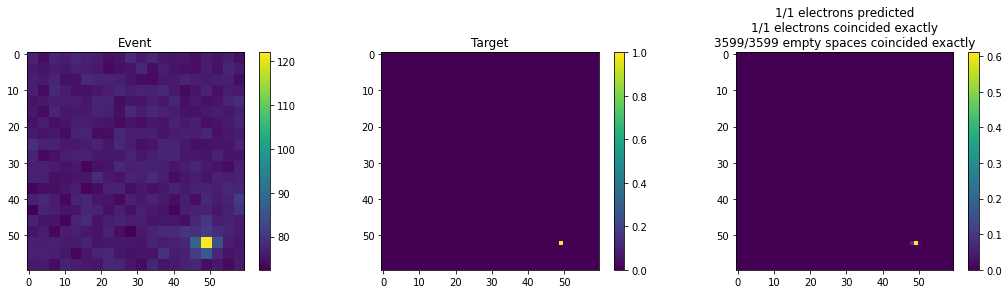

In [8]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.08
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))